In [10]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("/media/alit2204/OS/Project/Flickr8k/Project/tokens_clean8.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [11]:
print(type(content))

<class 'dict'>


In [12]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [13]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [14]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [15]:
threshold = 10

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 1850


PREPARE TRAIN AND TEST DATA

In [16]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""
dev_file_data =""

with open ("/media/alit2204/OS/Project/Flickr8k/Project/Text/Flickr_8k.trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("/media/alit2204/OS/Project/Flickr8k/Project/Text/Flickr_8k.testImages.txt", 'r') as file:
    test_file_data = file.read()

with open ("/media/alit2204/OS/Project/Flickr8k/Project/Text/Flickr_8k.devImages.txt", 'r') as file:
    dev_file_data = file.read()

In [17]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]
val_data= [img_file_name for img_file_name in dev_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]
val_data = [image.split(".")[0] for image in val_data]

In [18]:
train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [19]:
val_data[:5]

['2090545563_a4e66ec76b',
 '3393035454_2d2370ffd4',
 '3695064885_a6922f06b2',
 '1679557684_50a206e4a9',
 '3582685410_05315a15b8']

In [20]:
# For each imageID in train_data, store its captions in a dictionary

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [21]:
train_content['667626_18933d713e']

['startseq a girl is stretched out in shallow water endseq',
 'startseq a girl wearing a red and multi colored bikini is laying on her back in shallow water  endseq',
 'startseq a little girl in a red swimsuit is laying on her back in shallow water  endseq',
 'startseq a young girl is lying in the sand while ocean water is surrounding her  endseq',
 'startseq girl wearing a bikini lying on her back in a shallow pool of clear blue water  endseq']

In [22]:
# For each imageID in val_data, store its captions in a dictionary

validation_content = {}

for imageID in val_data:
    validation_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        validation_content[imageID].append(cap_to_append)

In [23]:
validation_content['2659183350_730951f740']

['startseq a boy in a red and white shirt kicks a large baseball while surrounded by people  endseq',
 'startseq a boy kicks a giant baseball while a group of children watch  endseq',
 'startseq a boy kicks a really large baseball endseq',
 'startseq a kid kicking a large ball while surrounded by other kids  endseq',
 'startseq children are outside playing with an oversized baseball  endseq']

EXTRACT FEATURES FROM IMAGES USING ConvNeXtXLarge ARCHIECTURE

In [24]:
from keras.applications.convnext import ConvNeXtXLarge, preprocess_input, decode_predictions

model = ConvNeXtXLarge(weights = 'imagenet', input_shape = (240, 240, 3))

In [25]:
model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 384, 384, 3)          0         ['input_3[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 192, 192, 24)         648       ['rescaling_1[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 192, 192, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                

In [26]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [27]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(240, 240))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 384, 384, 3)


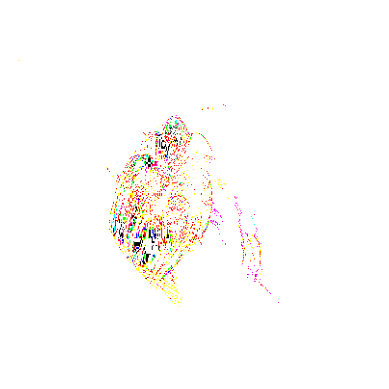

In [28]:
import matplotlib.pyplot as plt
import keras.utils as image
%matplotlib inline

img = preprocess_image("/media/alit2204/OS/Project/Flickr8k/Project/dataset/Flicker8k_Dataset/667626_18933d713e.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [29]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
import os
import pickle
from pickle import dump

def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [30]:
from time import time

filename = 'encoded_train_features08ENV2S.pkl'

if os.path.exists(filename):
    with open(filename, "rb") as file:
        train_encoding = pickle.load(file)
else:
    train_encoding = {}
    start_time = time()
    for index, imageID in enumerate (train_data):
        image_path = "/media/alit2204/OS/Project/Flickr8k/Project/dataset/Flicker8k_Dataset/" + imageID + ".jpg"

        train_encoding[imageID] = encode_image(image_path)

        # Print progress
        if index%100 == 0:
            print("Encoding in progress... STEP", index)

    end_time = time()
    print("Total time taken:", end_time-start_time, "sec")

    with open(filename, "wb") as file:
        # Pickle allows to store any object as a file on the disk
        pickle.dump(train_encoding, file)

In [45]:
filename = 'encoded_test_features08ENV2S.pkl'

if os.path.exists(filename):
    with open(filename, "rb") as file:
        test_encoding = pickle.load(file)
else:
    test_encoding = {}
    start_time = time()
    for index, imageID in enumerate (test_data):
        image_path = "/media/alit2204/OS/Project/Flickr8k/Project/dataset/Flicker8k_Dataset/" + imageID + ".jpg"

        test_encoding[imageID] = encode_image(image_path)

        # Print progress
        if index%100 == 0:
            print("Encoding in progress... STEP", index)

    end_time = time()
    print("Total time taken:", end_time-start_time, "sec")

    with open(filename, "wb") as file:
        # Pickle allows to store any object as a file on the disk
        pickle.dump(test_encoding, file)

In [46]:
filename = 'encoded_val_features08ENV2S.pkl'

if os.path.exists(filename):
    with open(filename, "rb") as file:
        validation_encoding = pickle.load(file)
else:
    validation_encoding = {}
    start_time = time()
    for index, imageID in enumerate (val_data):
        image_path = "/media/alit2204/OS/Project/Flickr8k/Project/dataset/Flicker8k_Dataset/" + imageID + ".jpg"

        validation_encoding[imageID] = encode_image(image_path)

        # Print progress
        if index%100 == 0:
            print("Encoding in progress... STEP", index)

    end_time = time()
    print("Total time taken:", end_time-start_time, "sec")

    with open(filename, "wb") as file:
        # Pickle allows to store any object as a file on the disk
        pickle.dump(validation_encoding, file)

PREPROCESS THE CAPTIONS

In [47]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [48]:
print(len(index_to_word))

1850


In [49]:
print(index_to_word[5])
print(word_to_index['is'])

is
5


In [50]:
# Add startseq and endseq also to the mappings
index_to_word[1851] = 'startseq'
word_to_index['startseq'] = 1851

index_to_word[1852] = 'endseq'
word_to_index['endseq'] = 1852

VOCAB_SIZE = len(word_to_index) + 1

In [51]:
print(VOCAB_SIZE)

1853


In [52]:
from pickle import dump
import pickle

with open("word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)
    dump(word_to_index, open('word_to_idx.pkl', 'wb'))

In [53]:
with open("idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [54]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [55]:
print(max_len)

38


In [56]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    embeddings_index = {}
    for line in fin:
        values = line.rstrip().split(' ')
        embeddings_index[values[0]] = np.array(values[1:], float)

    return embeddings_index
embedding_index=load_vectors('/media/alit2204/OS/Project/Flickr8k/Project/glove.6B.50d.txt')

def fastText(embedding_index):
  embedding_dim = 50
  embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

  for word, i in word_to_index.items():
      embedding_vector = embedding_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix,embedding_dim

embedding_matrix,embedding_dim=fastText(embedding_index)

In [57]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [58]:
embedding_matrix.shape

(1853, 50)

DEFINE MODEL ARCHITECTURE

In [66]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ConvNeXtXLarge goes into following input layer
inp_img_features = Input(shape=(1280,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(64, activation='relu')(inp_img1)

In [67]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(64)(inp_cap2)
# inp_cap3 captures the entire sentence that has been generated till now

In [68]:
from keras.layers import add

# Decode the inputs

# So, an image (224x224x3) goes through ConvNeXtXLarge
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(64, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [69]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1280)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 38, 50)               92650     ['input_7[0][0]']             
                                                                                                  
 dropout_3 (Dropout)         (None, 1280)                 0         ['input_6[0][0]']             
                                                                                            

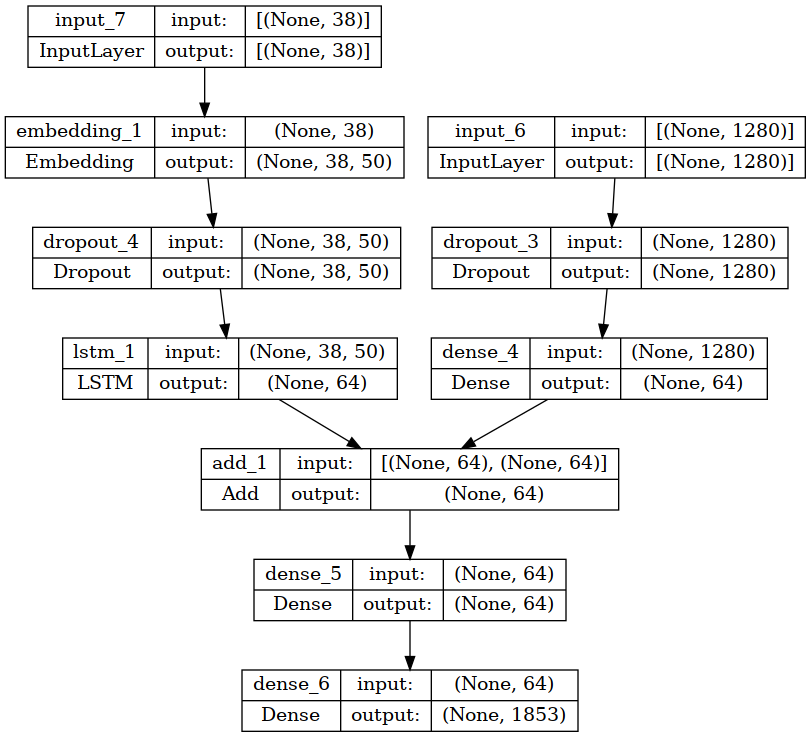

In [70]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [71]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [72]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [73]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]

                    X1, X2, y = [], [], []
                    n=0

In [74]:
def object_generator (validation_content, validation_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in validation_content.items():
            n += 1

            image = validation_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]

                    X1, X2, y = [], [], []
                    n=0

TRAIN THE MODEL

Epoch 1/100
750/750 [==============================] - 40s 49ms/step - loss: 4.4735 - accuracy: 0.2213 - val_loss: 3.8010 - val_accuracy: 0.2854
Epoch 2/100
750/750 [==============================] - 36s 48ms/step - loss: 3.6125 - accuracy: 0.2989 - val_loss: 3.4734 - val_accuracy: 0.3193
Epoch 3/100
750/750 [==============================] - 36s 48ms/step - loss: 3.3742 - accuracy: 0.3226 - val_loss: 3.3389 - val_accuracy: 0.3319
Epoch 4/100
750/750 [==============================] - 36s 48ms/step - loss: 3.2391 - accuracy: 0.3352 - val_loss: 3.2534 - val_accuracy: 0.3413
Epoch 5/100
750/750 [==============================] - 36s 48ms/step - loss: 3.1465 - accuracy: 0.3433 - val_loss: 3.1970 - val_accuracy: 0.3486
Epoch 6/100
750/750 [==============================] - 36s 48ms/step - loss: 3.0735 - accuracy: 0.3510 - val_loss: 3.1562 - val_accuracy: 0.3528
Epoch 7/100
750/750 [==============================] - 36s 48ms/step - loss: 3.0208 - accuracy: 0.3555 - val_loss: 3.1256 - val_ac

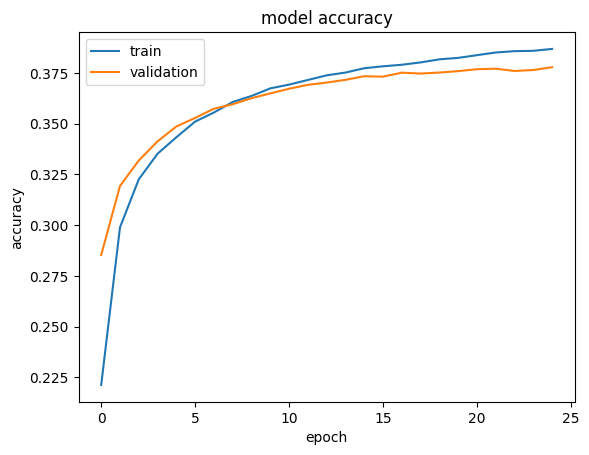

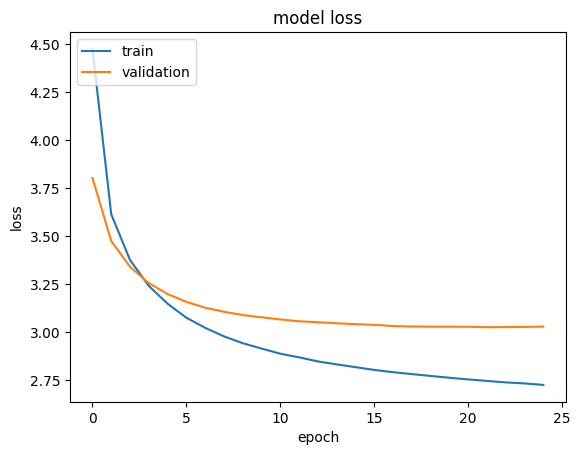

[3.8010473251342773,
 3.4734442234039307,
 3.3388683795928955,
 3.2533998489379883,
 3.196969509124756,
 3.15618634223938,
 3.1255831718444824,
 3.104626417160034,
 3.087397575378418,
 3.075925350189209,
 3.0646414756774902,
 3.0550105571746826,
 3.0502283573150635,
 3.0446901321411133,
 3.0399320125579834,
 3.036559820175171,
 3.029935121536255,
 3.027752161026001,
 3.026834011077881,
 3.026989459991455,
 3.02644681930542,
 3.0241777896881104,
 3.024894952774048,
 3.0254263877868652,
 3.027722120285034]

In [75]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

epochs =1
batch_size = 8
steps = len(train_content)//batch_size
validation_steps = len(validation_content)//batch_size

for i in range(epochs):
    # Create an instance of the generator for training data
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    # Create an instance of the generator for validation data
    validation_generator = object_generator(validation_content, validation_encoding, word_to_index, max_len, batch_size)
    history = model.fit(generator, epochs=100, steps_per_epoch=steps,
                        validation_data=validation_generator, validation_steps=validation_steps, verbose=1,
                        callbacks=[early_stopping])
    model.save('model_bestali1' + str(i) + '.keras')

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

training_accuracy
training_loss
validation_accuracy
validation_loss

In [76]:
model.load_weights('/home/alit2204/model_bestali10.keras')

In [77]:
images = '/media/alit2204/OS/Project/Flickr8k/Project/dataset/Flicker8k_Dataset/'

In [78]:
from pickle import dump, load
with open("encoded_test_features08ENV2S.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [79]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [80]:
z = 0

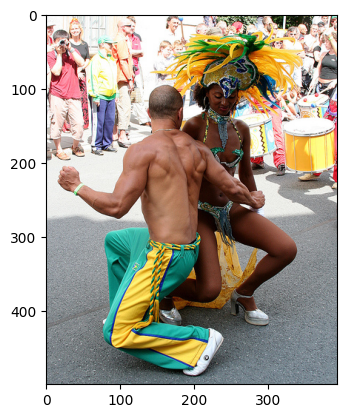

Greedy: a man in a white shirt and a white shirt and a white shirt and a white shirt
311146855_0b65fdb169


In [84]:
#z = 0
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,1280))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print(pic)

In [85]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        test_content[imageID].append(cap_to_append)

In [86]:
x = 0
pic = list(encoding_test.keys())[x]
test_content[pic]

['the dogs are in the snow in front of a fence ',
 'the dogs play on the snow ',
 'two brown dogs playfully fight in the snow ',
 'two brown dogs wrestle in the snow ',
 'two dogs playing in the snow ']

1258913059_07c613f7ff
Greedy Search Caption: a man in a black shirt and a black shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white

Reference 1: ['a couple of people sit outdoors at a table with an umbrella and talk ', 'three people are sitting at an outside picnic bench with an umbrella ', 'three people sit at an outdoor cafe ', 'three people sit at an outdoor table in front of a building painted like the union jack ', 'three people sit at a picnic table outside of a building painted like a union jack ']

BLEU-1: 0.141


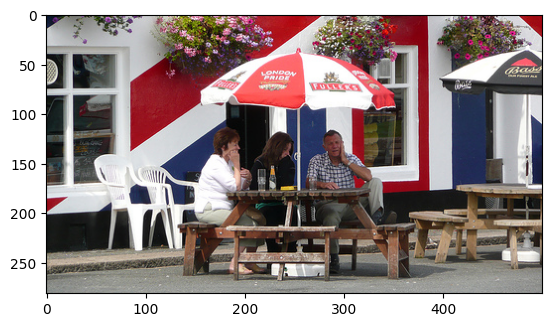

In [88]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 3
pic = list(encoding_test.keys())[x]
test_content[pic]


reference = test_content[pic]
#pic = list(encoding_test.keys())[1]
print(pic)
img = 'twodogs.jpg'
e = encoding_test[pic].reshape(1,1280)
#image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
#x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

In [89]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = [], []

for key in tqdm(test_data):
    # get actual caption
    captions = content[key]
    # predict the caption for image
    y_pred = greedySearch(image)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

 35%|███▍      | 346/1000 [03:28<06:34,  1.66it/s]


KeyboardInterrupt: 

In [ ]:
from rouge import Rouge
rouge = Rouge()
reference = " ".join(test_content[pic])
caption = greedySearch(e)
scores = rouge.get_scores(caption, reference)
print("Rouge Score:", scores)